In [18]:
from igraph import Graph
import pandas as pd

In [161]:
import igraph
import networkx as nx

In [106]:
nodes=pd.read_csv('Nodes_df4.csv')

In [28]:
edges=pd.read_csv('Edges_df4.csv')

In [21]:
edges.columns

Index(['Source', 'Target', 'Type', 'Kind', 'Id', 'Label', 'Interval',
       'Weight'],
      dtype='object')

#### prove con igraph

In [29]:
g=Graph.DataFrame(edges=edges[['Source','Target']],directed=True)

In [30]:
dendogram=g.community_edge_betweenness(directed=True)

In [160]:
clustered=dendogram.as_clustering(84)

In [49]:
giant_component=clustered.giant()
dendogram_giant=giant_component.community_edge_betweenness(directed=True)
clustered_giant=dendogram_giant.as_clustering(3)
clustered_giant_graph_nodes=clustered_giant.graph.vs["name"]

In [86]:
memberships=clustered_giant.membership

In [104]:
nodes_df=pd.DataFrame()

nodes_df['node']=clustered_giant_graph_nodes
nodes_df['cluster']=memberships

In [107]:
nodes.columns

Index(['Id', 'Label', 'Interval', 'Colour'], dtype='object')

In [187]:
nodes['Colour']='#aaaacc'

In [188]:
colour=[]
for index, row in nodes_df.iterrows():
    subset=nodes[nodes.Id==int(row['node'])]
    if subset.empty == False:
        sub_index=subset.index
        if row['cluster']==0:
            nodes.at[sub_index,'Colour']='#fb1239'
        if row['cluster']==1:
            nodes.at[sub_index,'Colour']='#007474'
        if row['cluster']==2:
            nodes.at[sub_index,'Colour']='#042069'
    else:
        continue

In [189]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

#### prove con networkx

In [168]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')

In [169]:
component_subgraph_list = list(nx.connected_components(g_nx))

In [172]:
largest_component = list(max(component_subgraph_list,key=len))

In [235]:
nodes=pd.read_csv('Nodes_df4.csv')

In [236]:
nodes

,Id,Label,Interval,Colour
0,321228288,marsion65,NaN,#fb1239
1,1426639026824564737,MaurizioCimino2,NaN,#fb1239
2,272945830,AleC226,NaN,#fb1239
3,745351426117869568,Massimi8900,NaN,#fb1239
4,798461063494828032,IvanoPioli,NaN,#fb1239
...,...,...,...,...
3730,280175586,nunziapenelope,NaN,#aaaacc
3731,1262438419755683840,MedicinePop,NaN,#aaaacc
3732,26143609,emmevilla,NaN,#aaaacc
3733,780706530811219968,Manuel_Pomaro,NaN,#aaaacc


In [200]:
nodes_list=list(nodes.Id)

In [205]:
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]

In [207]:
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [208]:
dendogram=new_g.community_edge_betweenness(directed=True)

In [214]:
clustered=dendogram.as_clustering(5)

In [216]:
eigen=new_g.community_leading_eigenvector(5)

C:\Users\Eric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


In [218]:
eigen.summary()

'Clustering with 3527 elements and 5 clusters'

In [225]:
eigen_nodes=eigen.graph.vs["name"]

In [232]:
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

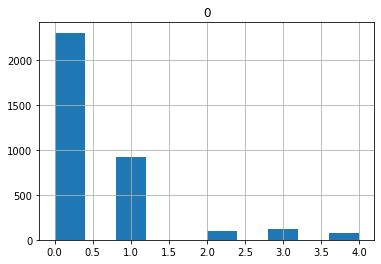

In [219]:
pd.DataFrame(eigen._membership).hist()

In [233]:
df_eigen

,nodes,clusters
0,2279301,0
1,5253961,0
2,5718002,1
3,6012422,0
4,6243422,0
...,...,...
3522,1474895624843800581,0
3523,1475049574809186307,0
3524,1475122883164876805,4
3525,1475496660268638210,0


In [198]:
df_rows=[]

for idx,row in nodes.iterrows():
    


,Source,Target,Type,Kind,Id,Label,Interval,Weight
0,321228288,1173223843,Directed,NaN,1,NaN,NaN,1.0
1,1426639026824564737,1364298062919794688,Directed,NaN,2,NaN,NaN,1.0
2,272945830,2380463039,Directed,NaN,3,NaN,NaN,1.0
3,745351426117869568,1238800491632607232,Directed,NaN,4,NaN,NaN,1.0
4,798461063494828032,1173223843,Directed,NaN,5,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
5582,613859050,231902290,Directed,NaN,5583,NaN,NaN,1.0
5583,40653660,77031813,Directed,NaN,5584,NaN,NaN,1.0
5584,709020928,542530025,Directed,NaN,5585,NaN,NaN,1.0
5585,195333276,231902290,Directed,NaN,5586,NaN,NaN,1.0


In [206]:
dendogram=new_edges.community_edge_betweenness(directed=True)

AttributeError: 'DataFrame' object has no attribute 'community_edge_betweenness'

In [240]:
nodes['Colour']='#aaaacc'

colour=[]
for index, row in df_eigen.iterrows():
    subset=nodes[nodes.Id==int(row['nodes'])]
    if subset.empty == False:
        sub_index=subset.index
        if row['clusters']==0:
            nodes.at[sub_index,'Colour']=1
        if row['clusters']==1:
            nodes.at[sub_index,'Colour']=2
        if row['clusters']==2:
            nodes.at[sub_index,'Colour']=3
        if row['clusters']==3:
            nodes.at[sub_index,'Colour']=4
        if row['clusters']==4:
            nodes.at[sub_index,'Colour']=5
    else:
        continue

In [195]:
nodes['Colour']='#aaaacc'

colour=[]
for index in eigen_nodes:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Colour']='#fb1239'
    else:
        continue

In [241]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)